In [1]:
# imports and rtlsdr setup

import time
import numpy as  np
import matplotlib.pyplot as plt
import sounddevice as sd
from copy import copy
np.set_printoptions(precision=2)

from rtlsdr import RtlSdr 

try: 
    sdr.close()
    print("SDR closed")
except NameError:
   print("No SDR instance found")

No SDR instance found


In [2]:
# getting samples from radio waves

sdr = RtlSdr()
fsps = 2*256*256*16 # =  ... about 2Msps...works
faudiosps =48000 # audio sampling frequency (for output)
#fc = 94.9e6 # KUOW Seattle
#fc = 95.4e6 # test for no signals
fc = 172.0e6 # Raspberry pi freq
dt = 1.0/fsps # time step size between samples
nyquist = fsps /2.0
Tmax = 5.0
N = round(fsps*Tmax) # N must be a multiple of 256
sdr.sample_rate = 2.4e6  # Sampling rate
sdr.center_freq = fc
sdr.gain = 42.0 # This is max, according to sdr.valid_gains_db

samples = ((np.zeros((N))+1j)-1j)
freqs = np.zeros((N))
spectrum = ((np.zeros((N))+1j)-1j)

In [3]:
# collect samples
samples = sdr.read_samples(N)

N=  10485760  fsps=  2097152  fcutoff= 30000  fcutoff_n=  0.01430511474609375  pbfw=  300000  sbw=  5092880
total=  10485760


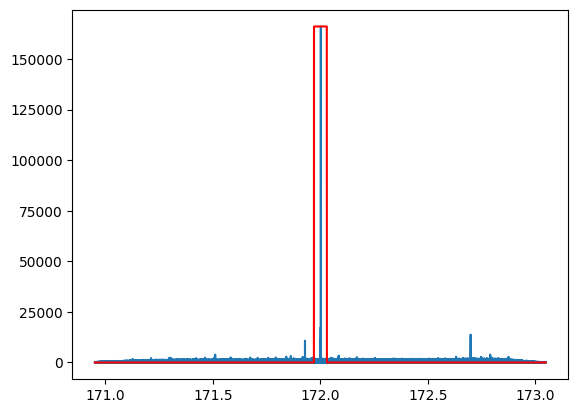

In [4]:
# filter noise

freqs = np.linspace(fc-nyquist,fc+nyquist,len(spectrum))
spectrum = np.fft.fftshift(np.fft.fft(samples))

def bandpassmask2(N,fsps,fcutoff):
    fcutoff_n = fcutoff / fsps # fcutoff, normalized

    pbfw = round(2*fcutoff_n*N)
    sbw = int((N-pbfw)/2)
    print("N= ", N, " fsps= ",fsps, " fcutoff=", fcutoff, " fcutoff_n= ",fcutoff_n," pbfw= ", pbfw, " sbw= ", sbw)
    res = np.concatenate((np.zeros(sbw),np.ones(pbfw),np.zeros(sbw)))
    print("total= ",pbfw+sbw+sbw)
    return(res)

bpm2 = bandpassmask2(N, fsps, 30000)
filteredspectrum = spectrum * bpm2
height = np.max(np.abs(spectrum))
plt.figure()
plt.plot(freqs/1e6,np.abs(spectrum))
plt.plot(freqs/1e6,height*bpm2,'r')

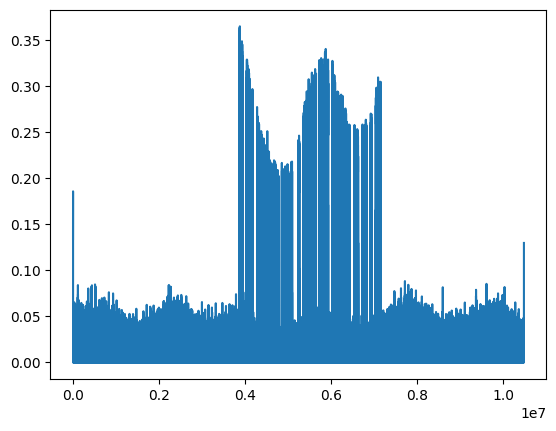

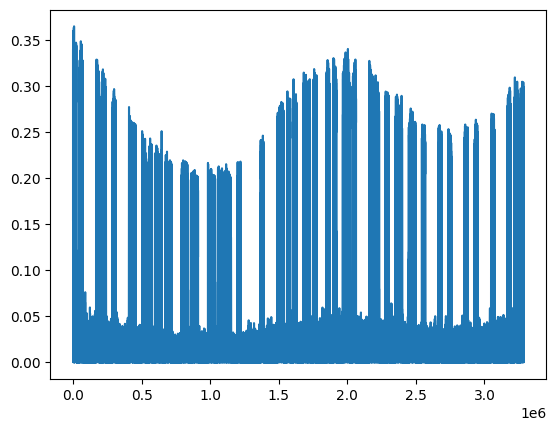

In [5]:
filteredsignal = np.fft.ifft(np.fft.fftshift(filteredspectrum))


filteredsignalreal = np.abs(np.real(filteredsignal))
# gets rid of a big spike at the beginning of the reading
temp = filteredsignalreal[1000000:len(filteredsignalreal)]

plt.figure()
plt.plot(filteredsignalreal)

# use 3/4 of the max height as the threshold to start reading bits
highest = max(temp)
lowest = min(temp)
#threshold = (highest + lowest) / 2
# the threshold is aways different lmao
threshold = 0.15
# find where the bits are
startingindex = 0
endingindex = 0

for i, val in enumerate(temp):
    if val > threshold:
        startingindex = i
        break
        
for i, val in reversed(list(enumerate(temp))):
    if (val > threshold):
        endingindex = i
        break;

# graph bits
bitstoread = temp[startingindex:endingindex]
plt.figure()
plt.plot(bitstoread)

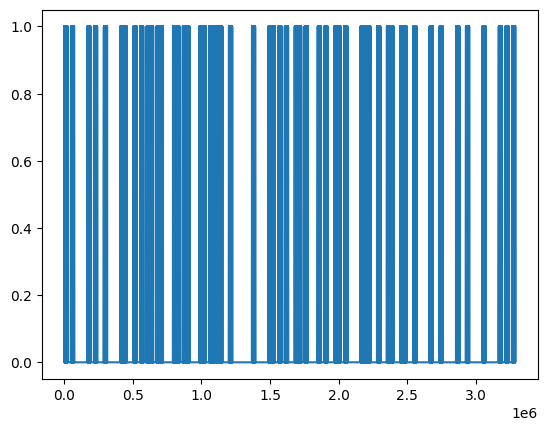

In [6]:
# clean the bit signals
cleanedbitstoread = np.zeros(len(bitstoread))

for i, val in enumerate(bitstoread):
    if val > threshold:
        cleanedbitstoread[i] = 1
    else:
        cleanedbitstoread[i] = 0

plt.figure()
plt.plot(cleanedbitstoread)

In [7]:
# turn to string form

bigbitstring = ""

                
for i in range(0, len(cleanedbitstoread), 1):
    val = cleanedbitstoread[i]
    if val == 1:
        bigbitstring = bigbitstring + "1"
    else:
        bigbitstring = bigbitstring + "0" 

print(bigbitstring)

1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

In [8]:
# turn the big bit string into a real bit string

def orderThingies(items):
    items2 = []
    # this might need to be calculated
    thresh = 1500
    count = 0
    for i in range(0, len(items), 1):
        val = int(items[i][1])
        if (val > thresh):
            items2.append(["1", count])
            items2.append(["0", val])
            count = 0
        else:
            count = count + val
    return items2


def countThingies(bits):
    items = []
    current_val = bits[0]
    count = 0
    for i in range(0, len(bits), 1):
        val = bits[i]
        if (current_val == val):
            count = count + 1
        else:
            items.append([current_val, count])
            if (current_val == "1"):
                current_val = "0"
            else:
                current_val = "1"
            count = 0
    return items


items = countThingies(bigbitstring)

items2 = orderThingies(items)
    
average_gap = (int(items2[0][1]) + int(items2[1][1]) + int(items2[2][1])) / 3

result = ""
for i in range(0, len(items2), 1):
    val = int(items2[i][1])
    reps = round(val / average_gap)
    for _ in range(0, reps, 1):
        result += items2[i][0]

        
#result = result[0:len(result) - 1]
print(result)

1010000101001000011001010110110001101100011011110010000001000011010100110100010100110100001110010011001100100001001000010010000100001010


In [9]:
# convert bits to file

binMap = {
    "0001" : "txt",
    "0010" : "png"
}

def bits_to_bytes(bits):
    bytes_array = bytearray()
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        byte_value = int(byte, 2)
        bytes_array.append(byte_value)
    return bytes_array

def bytes_to_file(bytes, file_type):
    f = open(f'output.{file_type}', 'wb')
    f.write(bytes)
    f.close()


file_type = binMap[result[4:8]]
bits = result[8:]
bytes = bits_to_bytes(bits)
bytes_to_file(bytes, file_type)



